# Feasibility of Repurposing Abandoned Oil and Gas Wells into Geothermal Power Generation: A Machine Learning-Driven Classification Analysis

# 1. Introduction

The repurposing of abandoned oil and gas wells for geothermal energy production has transitioned from academic concept to operational reality. Between 1987 and 2025, international projects across 12 countries (USA, Iceland, France, Switzerland, Germany, Japan, Australia, South Korea, China, Hungary, Indonesia, and Colombia) have demonstrated technical feasibility through field implementation. Global research institutions and energy companies have published peer-reviewed technical studies establishing both closed-loop and open-loop conversion pathways

However, the success rate of completed projects remains below 40%, with failure modes concentrated in well selection criteria, subsurface characterization, fluid dynamics performance, and technical design decisions. Most conversion projects lack adequate ex-ante quantitative screening protocols, relying instead on qualitative domain assessment. This gap creates persistent uncertainty regarding capital allocation and project selection.

**Research Objective**: This feasibility study applies machine learning classification methodology to historical project data to develop a quantitative model capable of predicting the probability of successful well conversion. The model's primary purpose is to enable evidence-based portfolio screening for conversion candidates, reducing project selection uncertainty and improving capital 

**Scope**: Analysis of 24 international abandoned well conversion projects spanning multiple geothermal conversion technologies, geographies, geological formations, and operational regimes

# 2. Importing Libraries

## 2.1 EDA and Machine Learning Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    PrecisionRecallDisplay,
    RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import plot_importance
from lime import lime_tabular
import shap
import pickle

## 2.2 Basic Perimeter

In [3]:
random_state = 88
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# 3. Data Loading and Explanatory Data Analysis

In [4]:
df = pd.read_csv('geothermal_classification_data.csv')
df

,Project_ID,Project_Name,Location,Country,Year_Started,Well_Type,Well_Depth_m,Bottomhole_Temp_C,Flow_Rate_m3_day,Flow_Rate_Stability_pct,...,Cement_Quality_Known,Distance_to_Demand_km,Seismic_Risk_Zone,Permeability_mD,TDS_mg_L,H2S_ppm,Conversion_Type,Technology,Duration_Years,Success
0,PROJ_001,RMOTC Phase II,Wyoming,USA,2010,Oil_coproduction,2100.0,95,6350,12,...,1,35,0,50.0,3500,50,Open_Loop,ORC_air_cooled,3.50,1
1,PROJ_002,Laurel Oilfield,Mississippi,USA,2011,Oil_coproduction,2900.0,95,648,8,...,1,25,0,45.0,4200,60,Open_Loop,ORC_water_cooled,0.50,1
2,PROJ_003,Huabei Oilfield,China,China,2011,Oil_coproduction,2200.0,110,2850,15,...,1,15,1,35.0,5800,150,Open_Loop,ORC_screw_expander,2.00,1
3,PROJ_004,Williston Basin Phase 1,North Dakota,USA,2016,Gas_coproduction,2350.0,103,4400,18,...,1,40,0,40.0,3200,40,Open_Loop,ORC_insulated,0.01,0
4,PROJ_005,Las Maracas Field,Colombia,Colombia,2021,Oil_coproduction,2400.0,85,500,20,...,0,20,0,15.0,4000,30,Open_Loop,ORC_small,1.00,1
5,PROJ_006,Texas Pilot,Texas,USA,2015,Oil_gas_coproduction,1800.0,110,2000,85,...,0,120,0,8.0,8500,200,Open_Loop,ORC_basic,0.50,0
6,PROJ_007,HGP-A Hawaii,Hawaii,USA,1991,Geothermal_adapted,876.5,110,100,5,...,1,30,0,100.0,2500,5,Closed_Loop_BHE,U_tube_BHE,5.00,1
7,PROJ_008,Weissbad BHE,Switzerland,Switzerland,1996,Low_permeability_closed_loop,1600.0,100,300,30,...,0,50,1,0.5,6000,100,Closed_Loop_BHE,U_tube_BHE,5.00,0
8,PROJ_009,Weggis BHE,Switzerland,Switzerland,1994,Low_permeability_closed_loop,2300.0,105,500,35,...,0,55,1,0.8,7200,120,Closed_Loop_BHE,U_tube_BHE,3.00,0
9,PROJ_010,RWTH-Aachen Campus,Germany,Germany,2004,Planned_BHE,2500.0,100,0,0,...,0,10,0,0.0,0,0,Closed_Loop_BHE,Deep_BHE_planned,0.00,0


In [5]:
df.describe()

,Year_Started,Well_Depth_m,Bottomhole_Temp_C,Flow_Rate_m3_day,Flow_Rate_Stability_pct,Power_Output_kW,Well_Age_Years,Cement_Quality_Known,Distance_to_Demand_km,Seismic_Risk_Zone,Permeability_mD,TDS_mg_L,H2S_ppm,Duration_Years,Success
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,2005.958333,2657.354167,148.458333,1995.750000,30.541667,2034.875000,23.875000,0.458333,55.916667,0.458333,25.291667,5412.500000,216.875000,5.500417,0.375000
std,13.375770,1083.001149,52.337516,1696.991846,23.010355,3321.081873,16.448371,0.508977,39.039463,0.508977,32.117257,2458.403954,234.482838,8.520793,0.494535
min,1974.000000,876.500000,85.000000,0.000000,0.000000,0.000000,5.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1995.500000,2075.000000,102.250000,500.000000,12.000000,100.000000,9.750000,0.000000,25.000000,0.000000,1.100000,3500.000000,47.500000,1.000000,0.000000
50%,2010.500000,2500.000000,122.500000,1900.000000,22.500000,340.000000,20.500000,0.000000,47.500000,0.000000,9.000000,5500.000000,135.000000,2.500000,0.000000
75%,2017.250000,3125.000000,212.500000,2812.500000,46.250000,2125.000000,35.750000,1.000000,81.250000,1.000000,41.250000,7275.000000,325.000000,5.000000,1.000000
max,2021.000000,5000.000000,220.000000,6350.000000,85.000000,11400.000000,65.000000,1.000000,150.000000,1.000000,100.000000,10000.000000,800.000000,37.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Project_ID               24 non-null     object 
 1   Project_Name             24 non-null     object 
 2   Location                 24 non-null     object 
 3   Country                  24 non-null     object 
 4   Year_Started             24 non-null     int64  
 5   Well_Type                24 non-null     object 
 6   Well_Depth_m             24 non-null     float64
 7   Bottomhole_Temp_C        24 non-null     int64  
 8   Flow_Rate_m3_day         24 non-null     int64  
 9   Flow_Rate_Stability_pct  24 non-null     int64  
 10  Power_Output_kW          24 non-null     int64  
 11  Well_Age_Years           24 non-null     int64  
 12  Cement_Quality_Known     24 non-null     int64  
 13  Distance_to_Demand_km    24 non-null     int64  
 14  Seismic_Risk_Zone        24 

In [7]:
px.histogram(df, x='Country')

In [8]:
px.histogram(df, x='Well_Type', color='Country')

In [9]:
fig = px.scatter(
    df,
    x='Bottomhole_Temp_C',
    y='Well_Depth_m',
    color='Success',
    size='Flow_Rate_m3_day',
    color_discrete_map={
        1: 'green',
        0: 'red'      
    },
    size_max=30
)
fig.update_layout(
    title=dict(
        text='Success Drivers in Geothermal Well Conversion based on Bottomhole Temperature and Well Depth',
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='Parameter',
    yaxis_title='Average Value',
)

fig.show()

In [10]:
agg = df.groupby('Success').agg(
    Well_Depth_m     = ('Well_Depth_m', 'mean'),
    Bottomhole_Temp_C= ('Bottomhole_Temp_C', 'mean'),
    Flow_Rate_m3_day = ('Flow_Rate_m3_day', 'mean'),
    Power_Output_kW  = ('Power_Output_kW', 'mean'),
    Permeability_mD  = ('Permeability_mD', 'mean')
).reset_index()

agg_long = agg.melt(
    id_vars='Success',
    var_name='Parameter',
    value_name='Average_Value'
)

agg_long['Success'] = agg_long['Success'].map({1: 'Successful', 0: 'Failed'})
param_labels = {
    'Well_Depth_m': 'Well Depth (m)',
    'Bottomhole_Temp_C': 'Temperature (°C)',
    'Flow_Rate_m3_day': 'Flow Rate (m³/day)',
    'Power_Output_kW': 'Power Output (kW)',
    'Permeability_mD': 'Permeability (mD)'
}
agg_long['Parameter'] = agg_long['Parameter'].map(param_labels)

fig = px.bar(
    agg_long,
    x='Parameter',
    y='Average_Value',
    color='Success',
    barmode='group',
    color_discrete_map={
        'Successful': '#00C8A3',  # teal
        'Failed': '#FF4B5C'       # red
    },
    text='Average_Value'
)

fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')

fig.update_layout(
    title=dict(
        text='Success Drivers in Geothermal Well Conversion',
        x=0.5,
        xanchor='center'
    ),
    xaxis_title='Parameter',
    yaxis_title='Average Value',
)

fig.show()

# 4. Target, features, splitting

In [11]:
target = 'Success'
categorical_features = ['Well_Type', 'Country', 'Conversion_Type','Technology']
numerical_features = ['Well_Depth_m', 'Bottomhole_Temp_C', 'Flow_Rate_m3_day', 'Power_Output_kW', 'Permeability_mD','TDS_mg_L','H2S_ppm','Well_Age_Years','Flow_Rate_Stability_pct','Distance_to_Demand_km']
X= df.drop(columns=[target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# 5. Feature Engineering

In [12]:
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())])
preprocessor_scaler = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_features),
    ('numerical', numerical_pipeline, numerical_features)
])
preprocessor = ColumnTransformer([
    ('categorical', categorical_pipeline, categorical_features),
    ('numerical', 'passthrough', numerical_features)
])

# 6. Base Model Selection

In [13]:
models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor_scaler),
        ('classifier', LogisticRegression())
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor_scaler),
        ('classifier', KNeighborsClassifier())
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier())
    ]),
    'AdaBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', AdaBoostClassifier())
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier())
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier())
    ])}

results = {}

In [14]:
for name, model in models.items():
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv_strategy,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc'
        },
        n_jobs=-1
    )
    results[name] = cv_results

In [15]:
tidy_rows = []

for name, cv_res in results.items():
    row = {
        'Model': name,
        'Accuracy_mean':  np.mean(cv_res['test_accuracy']),
        'Precision_mean': np.mean(cv_res['test_precision']),
        'Recall_mean':    np.mean(cv_res['test_recall']),
        'F1_mean':        np.mean(cv_res['test_f1']),
        'ROC_AUC_mean':   np.mean(cv_res['test_roc_auc']),
    }
    tidy_rows.append(row)

tidy_df = pd.DataFrame(tidy_rows).set_index('Model')
tidy_df = tidy_df.round(3)   # round for readability

display(tidy_df)

,Accuracy_mean,Precision_mean,Recall_mean,F1_mean,ROC_AUC_mean
Model,,,,,
Logistic Regression,0.733,0.600,0.6,0.567,0.717
KNN,0.633,0.467,0.6,0.467,0.725
Decision Tree,0.783,0.733,0.9,0.760,0.817
AdaBoost,0.783,0.533,0.8,0.627,0.767
Gradient Boosting,0.883,0.833,1.0,0.893,0.900
Random Forest,0.883,0.900,0.9,0.867,0.850
XGBoost,0.900,0.833,1.0,0.893,0.917
LightGBM,0.633,0.000,0.0,0.000,0.500


# 7. Hyperparameter Tuning

In [16]:
xgb_param_dist = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [4, 6, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(random_state=random_state, verbosity=0))
])

xgb_grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_dist,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best parameters: {xgb_grid_search.best_params_}")
print(f"Best CV F1 Score: {xgb_grid_search.best_score_:.4f}")

Best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__n_estimators': 150, 'model__subsample': 0.8}
Best CV F1 Score: 0.9600


In [17]:
print('----------classification_report-----------')
print(classification_report(y_test, xgb_grid_search.predict(X_test)))

----------classification_report-----------
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5



In [18]:
print('----------confusion_matrix-----------')
print(confusion_matrix(y_test, xgb_grid_search.predict(X_test)))

----------confusion_matrix-----------
[[2 1]
 [0 2]]


In [19]:
cv_results = cross_validate(
        xgb_grid_search,
        X_train,
        y_train,
        cv=cv_strategy,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc'
        },
        n_jobs=-1
    )
results['Tuned XGB'] = cv_results

In [20]:
comparison_df = pd.DataFrame({
    'Model Type': ['Baseline XGB','Tuned XGB'],
    'accuracy_score': [results['XGBoost']['test_accuracy'].mean(), results['Tuned XGB']['test_accuracy'].mean()],
    'precision_score': [results['XGBoost']['test_precision'].mean(), results['Tuned XGB']['test_precision'].mean()],
    'recall_score': [results['XGBoost']['test_recall'].mean(), results['Tuned XGB']['test_recall'].mean()],
    'f1_score': [results['XGBoost']['test_f1'].mean(), results['Tuned XGB']['test_f1'].mean()],
    'roc_auc_score': [results['XGBoost']['test_roc_auc'].mean(), results['Tuned XGB']['test_roc_auc'].mean()]
})
comparison_df

,Model Type,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
0,Baseline XGB,0.9,0.833333,1.0,0.893333,0.916667
1,Tuned XGB,0.9,0.833333,1.0,0.893333,1.000000


# 8 Cost Benefit Analysis and Interpretable Model (SHAP)

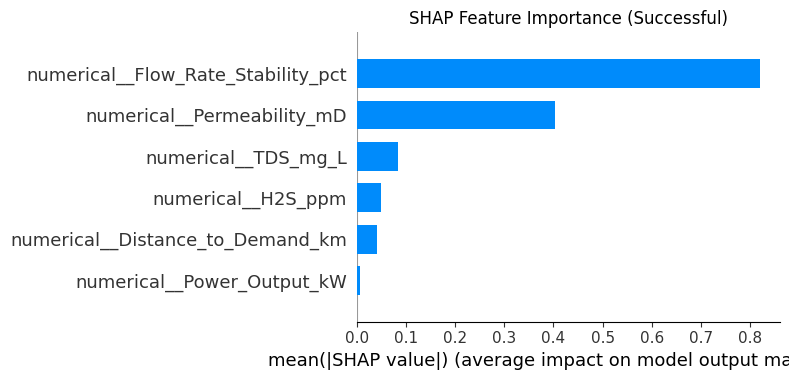

In [33]:
best_xgb = xgb_grid_search.best_estimator_
xgb_model = best_xgb.named_steps["model"]
X_test_trans = best_xgb.named_steps["preprocessor"].transform(X_test)
X_test_trans = X_test_trans.toarray()  # or keep sparse if SHAP supports
feature_names = best_xgb.named_steps["preprocessor"].get_feature_names_out()
X_test_shap = pd.DataFrame(X_test_trans, columns=feature_names)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_shap, check_additivity=False)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False,max_display=6)
plt.title("SHAP Feature Importance (Successful)")
plt.tight_layout()
plt.show()


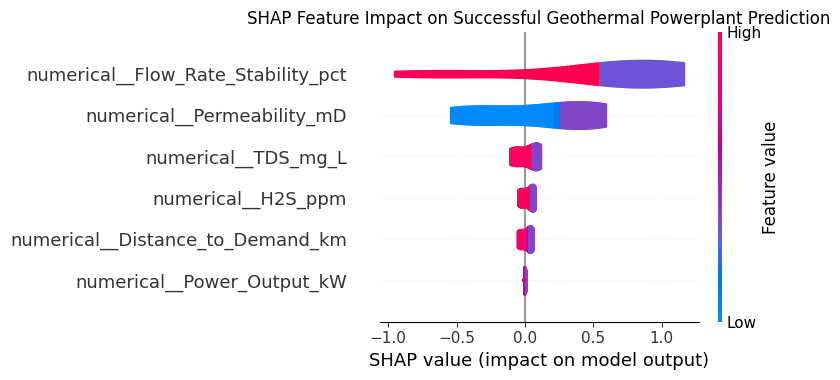

In [34]:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_shap, plot_type="violin", show=False, max_display=6)
plt.title("SHAP Feature Impact on Successful Geothermal Powerplant Prediction")
plt.tight_layout()
plt.show()

# 9. Model Deployment

In [ ]:
pickle.dump(xgb_grid_search.best_estimator_, open('xgb_model.sav', 'wb'))

In [ ]:
pipe = pickle.load(open("xgb_model.sav", "rb"))

In [ ]:
print('predict class :',pipe.predict(df[5:7]))
print('predict proba :',pipe.predict_proba(df[5:7]))

predict class : [0 1]
predict proba : [[0.850451   0.149549  ]
 [0.28140116 0.71859884]]
